In [233]:
import numpy as np
import pandas as pd
from pymystem3 import Mystem

from scipy.sparse import find
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [173]:
train_df = pd.read_parquet('cache/train.parquet')
test_df = pd.read_parquet('cache/test.parquet')
train_df

,text,score
id,,
1,"@mkomov Максим, Вашем письмо мы получили. Наши...",0
2,«Мегафон» стал владельцем 50% акций «Евросети»,0
3,RT @fuckkiev: “@EvaKobb: МТС Россия прислала ж...,-1
4,ВИДЕО: http://t.co/PSMLAhR4fI Реклама со смехо...,1
5,"@parfenov1960 потому что МТС достало, а пчел н...",-1
...,...,...
4996,Блогеры и журналисты Ставрополя публично проте...,0
4997,В Крыму полностью отключили инфраструктуру «МТ...,-1
4998,Кавказский #МегаФон предлагает новым корпорати...,1


In [174]:
X_train, y_train = train_df['text'], train_df['score']
X_test, y_test = test_df['text'], test_df['score']

In [175]:
def where(mask, val):
    out = mask.copy()
    rows, cols, _ = find(mask)
    for r, c in zip(rows, cols):
        out[r, c] = val
    return out

In [176]:
class LemmaTokenizer:
    def __init__(self):
        self.m = Mystem()

    def __call__(self, doc):
        return list(filter(
            lambda s: len(s.strip()) > 0,
            self.m.lemmatize(doc)))

In [177]:
v = CountVectorizer(min_df=4, strip_accents='unicode', tokenizer=LemmaTokenizer())
_ = v.fit(X_train)

/Users/paperlark/miniforge3/envs/text-analysis/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(min_df=4, strip_accents='unicode',
                tokenizer=<__main__.LemmaTokenizer object at 0x15b0fed60>)

In [219]:
pipe = Pipeline(steps=[
    ('vectorizer', CountVectorizer(strip_accents='unicode', tokenizer=LemmaTokenizer(), max_df=0.95, min_df=1)),
    ('transformer', TfidfTransformer(sublinear_tf=True, use_idf=True)),
    ('classifier', SVC(random_state=2021, decision_function_shape='ovo'))
])

param_grid = {
    # 'vectorizer__min_df': np.linspace(start=0, stop=0.05, num=6),
    # 'vectorizer__max_df': np.linspace(start=0.95, stop=1, num=6),
    # 'vectorizer__tokenizer': [None, LemmaTokenizer()],
    # 'transformer': [
    #     FunctionTransformer(lambda x: where(x > 0, 1)),
    #     TfidfTransformer(sublinear_tf=False, use_idf=False), # nnc
    #     TfidfTransformer(sublinear_tf=True, use_idf=False), # lnc
    #     TfidfTransformer(sublinear_tf=False, use_idf=True), # ntc
    #     TfidfTransformer(sublinear_tf=True, use_idf=True), # ltc
    # ],
    'classifier__gamma': np.linspace(start=0, stop=1, num=10),
    'classifier__decision_function_shape': ['ovo', 'ovr'],
}

cv = GridSearchCV(
    pipe,
    param_grid,
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=3, random_state=2021, shuffle=True),
    scoring='accuracy',
)
_ = cv.fit(X_train, y_train)

In [245]:
print('SVC mean train accuracy: {:.3}'.format(cv.best_score_))
print('Optimal params: {}'.format(cv.best_params_))

SVC mean train accuracy: 0.759
Optimal params: {'classifier__decision_function_shape': 'ovo', 'classifier__gamma': 1.0}


In [246]:
y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

          -1      0.546     0.763     0.636       879
           0      0.853     0.775     0.812      2595
           1      0.402     0.280     0.330       371

    accuracy                          0.724      3845
   macro avg      0.600     0.606     0.593      3845
weighted avg      0.739     0.724     0.725      3845



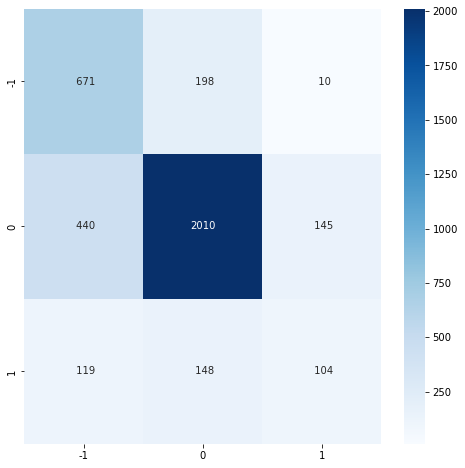

In [247]:
plt.figure(figsize=(8,8))
fig = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='4', cmap='Blues', xticklabels=(-1, 0, 1), yticklabels=(-1, 0, 1))
plt.savefig('cache/confusion.png')